# Brazil soybeans crop model using Gro API
In this notebook, we walk through the process of building a simple "crop model" using data in Gro. The accompanying Gro web app display for [Brazil Soybeans](https://app.gro-intelligence.com/displays/25894) provides an overview of the data series we will use. The crop model we will create is a very basic  model that uses crop-production-weighted NDVI to forecast  yield.

## Preliminary
First we construct a `CropModel` object. We also save the entity ids for the `item` [soybeans](https://app.gro-intelligence.com/dictionary/items/270), the `region` [Brazil](https://app.gro-intelligence.com/dictionary/regions/1029), the `metric` [yield](https://app.gro-intelligence.com/dictionary/metrics/170037) and yield units (sources report yield in different units, we specify tonnes per hectare so they'll be converted to a consistent unit for model training). We will use these throughout the notebook to simplify the retrieval, storage and manipulation of data.

In [1]:
import os
from api.client.crop_model import CropModel

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
country_id = model.search_for_entity('regions', "brazil")
crop_id =  model.search_for_entity('items', "soybeans")
yield_id = model.search_for_entity('metrics', "yield mass/area")
TONNES_PER_HECTARE_UNIT_ID = 61

In [2]:
# Quiet logs for demonstration purposes:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(level=logging.ERROR)

##  Historical yields
To get data series for national level soybeans yield for Brazil, we set the entities (item, metric and region), and get the available data series.  Note that there are multiple data series in this case because there are a few different <em>sources</em> that report the Brazil soybeans yields: [FAO](https://app.gro-intelligence.com/dictionary/sources/2), [PS&D](https://app.gro-intelligence.com/dictionary/sources/14), [IGC](https://app.gro-intelligence.com/dictionary/sources/19), and [IBGE](https://app.gro-intelligence.com/dictionary/sources/114). 

In [3]:
yield_entities = {}
yield_entities['item_id']  = crop_id
yield_entities['region_id'] = country_id
yield_entities['metric_id'] = yield_id

data_series_list = model.get_data_series(**yield_entities)
print("There are {} data series for {}.".format(len(data_series_list), yield_entities))

There are 5 data series for {'item_id': 270, 'region_id': 1029, 'metric_id': 170037}.


Each source covers a slightly different time range. Here we simply take all of them as training data, to have maximum coverage. We exclude source 32, the [Gro Yield Model](https://app.gro-intelligence.com/dictionary/sources/32), since that is itself a forecast from Gro's more sophisticated automated yield models, as discussed in the conclusion below.

In [4]:
GRO_YM_SOURCE_ID = 32
for data_series in data_series_list:
    if data_series['source_id'] == GRO_YM_SOURCE_ID:
        continue
    data_series['unit_id'] = TONNES_PER_HECTARE_UNIT_ID
    print("source_id {}: {} to {}".format(
        data_series['source_id'], data_series['start_date'], data_series['end_date']))
    model.add_single_data_series(data_series)

source_id 2: 1961-01-01T00:00:00.000Z to 2017-12-31T00:00:00.000Z
source_id 14: 1977-01-01T00:00:00.000Z to 2019-12-31T00:00:00.000Z
source_id 19: 2003-01-01T00:00:00.000Z to 2017-12-31T00:00:00.000Z
source_id 114: 1974-01-01T00:00:00.000Z to 2018-12-31T00:00:00.000Z


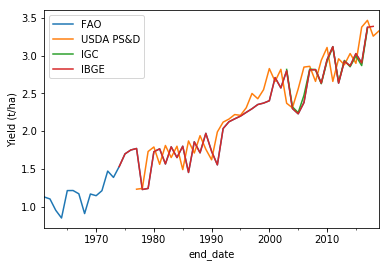

In [5]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

df = model.get_df()
yield_df = df.loc[(df.metric_id == yield_entities['metric_id']) & \
                  (df.region_id == yield_entities['region_id'])]
yield_df.end_date = pandas.to_datetime(yield_df.end_date)
yield_df.set_index('end_date')
fig, axes = plt.subplots(1, 1)
for source_id, group in yield_df.groupby('source_id'):
    group.plot(x='end_date', y='value', ax=axes, 
               label=model.lookup('sources', source_id)['name'])
plt.ylabel("Yield (t/ha)")
plt.show()

## Production "weight" of provinces
We compute the "weight" of each province, based on the full history of production quantity per province. The weights are normalized to add up to 1.0. A weight of 0.2 means we expect that province to account for 20% of the country's production.

In [6]:
provinces = model.get_provinces("brazil")
weights = model.compute_weights("soybeans", "Production Quantity mass", provinces)
max_weight = max(filter(lambda x: x >0, weights))
print ('Total weight: {}'.format(sum(filter(lambda x: x >0, weights))))
print ('Maximum weight: {}'.format(max_weight))

Total weight: 1.0
Maximum weight: 0.246717195965


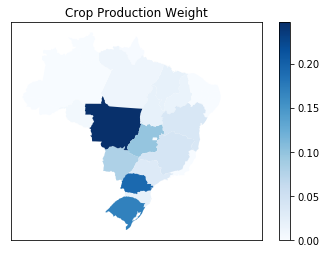

In [7]:
import geopandas
from shapely.geometry import shape

gdf = geopandas.GeoDataFrame([{
       'region_id': province['id'], 
       'geometry': shape(model.get_geojson(province['id'])['geometries'][0]),
       'production_weight': weight if weight > 0 else 0
    } for (province, weight) in zip(provinces, weights)])
gdf.set_index('region_id')

fig, axes = plt.subplots(1, 1)
gdf.plot(column='production_weight', 
         cmap='Blues', ax=axes, vmin=0, vmax=max_weight, legend=True)
axes.set_title('Crop Production Weight')
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
plt.show()

## NDVI, province level
The main signal we will use to model crop yields is [NDVI](https://app.gro-intelligence.com/dictionary/items/321), which represents vegetation biomass per pixel, and thus is a good physical proxy for yield (production mass per unit of area).

First we load the historical data for province level NDVI.  Here, there  are actually two data series for each region, one with `8-day` and one with `16-day` periods. We choose to use the series with 8-day (frequency_id = 3).

In [8]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Vegetation NDVI")
entities['metric_id'] = model.search_for_entity('metrics', "Vegetation Indices index")
EIGHT_DAY_FREQUENCY_ID = 3
entities['frequency_id'] = EIGHT_DAY_FREQUENCY_ID

for province in provinces:
    entities['region_id'] = province['id']
    for data_series in model.get_data_series(**entities):
        model.add_single_data_series(data_series)

## NDVI crop-weighted, province level
NDVI represents the biomass  of <em>all</em> vegetation, not just soybeans. To make it a more accurate signal, we compute the crop-weighted version of NDVI, using [compute_crop_weighted_series](https://developers.gro-intelligence.com/api.html#api.client.crop_model.CropModel.compute_crop_weighted_series). Note that NDVI data series exist at different frequencies, and this method will compute the crop-weighted version for all frequencies. Here we will limit ourselves to the 8-day frequency.

In [9]:
soy_ndvi_df = model.compute_crop_weighted_series(
    'soybeans', 'Production Quantity mass',
    'Vegetation NDVI', 'Vegetation Indices index',
    provinces)
soy_ndvi_df = soy_ndvi_df.loc[soy_ndvi_df.frequency_id == EIGHT_DAY_FREQUENCY_ID]

Now let's look at NDVI by province, on a particular date. First, we select NDVI for all provinces from the model's dataframe, and join it with the geopandas dataframe that has the provinces geometry.   Second, we select the crop weighted NDVI for all provinces from the `soy_ndvi_df` dataframe and do the same.

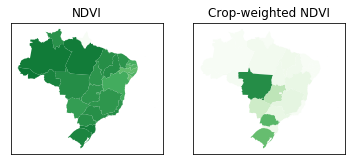

In [10]:
EVAL_DATE = u'2019-02-25T00:00:00.000Z'
df = model.get_df()
ndvi_df = df.loc[(df.metric_id == entities['metric_id']) & \
                 (df.end_date == EVAL_DATE),:]
gdf1 = gdf.join(ndvi_df.set_index('region_id'), on='region_id')

cwndvi_df = soy_ndvi_df.loc[(soy_ndvi_df.metric_id == entities['metric_id']) & \
                            (soy_ndvi_df.end_date == EVAL_DATE), :]
gdf2 = gdf.join(cwndvi_df.set_index('region_id'), on='region_id')

fig, axes = plt.subplots(1, 2)
gdf1.plot(column='value', 
          cmap='Greens', ax=axes[0], vmin=0.0, vmax=1.0)
axes[0].set_title('NDVI')
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
gdf2.plot(column='value', 
          cmap='Greens', ax=axes[1], vmin=0.0, vmax=max_weight)
axes[1].set_title('Crop-weighted NDVI')
axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(False)
plt.show()

## NDVI, country level
NDVI is available as a data series at all region levels, so we just add it to the model at the country level.

In [11]:
entities['region_id'] = country_id
for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)
df = model.get_df()
df.end_date = pandas.to_datetime(df.end_date, utc=True)
country_ndvi_df = df.loc[(df.metric_id == entities['metric_id']) & \
                         (df.region_id == entities['region_id'])]

For crop weighted NDVI, we need to aggregate it up from provinces. Since the crop-weighted NDVI series was built with weights normalized to 1.0, the sum of province level values is the national level value, for each date.

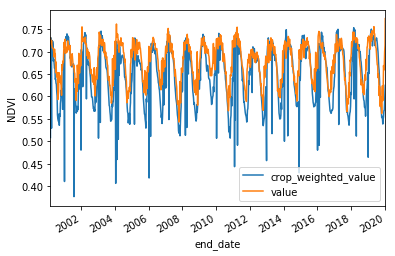

In [12]:
soy_ndvi_df.end_date = pandas.to_datetime(soy_ndvi_df.end_date, utc=True)
soy_ndvi_df.set_index('end_date')
country_ndvi_df.set_index('end_date')

country_ndvi_df = country_ndvi_df.merge(pandas.DataFrame([{
    'end_date': end_date,
    'crop_weighted_value': value
} for (end_date, value) in zip(soy_ndvi_df.end_date, 
                               soy_ndvi_df.groupby(['end_date']).sum().value)]))

fig, axes = plt.subplots(1, 1)
country_ndvi_df.plot(x='end_date', y=['crop_weighted_value', 'value'], ax=axes)
plt.ylabel('NDVI')
plt.show()

## Relationship between  yield and crop-weighted NDVI
On any day during the season, we can look at crop weighted NDVI as a rough aproximation of the amount of soybeans being grown per unit of area. Let's see if this would work as a predictor of the final yield of the crop for the current year. For this example, we pick February 25th of each year, which, as we can see from the crop calendar for this crop on our [display](https://app.gro-intelligence.com/displays/25894), is the end of the growth period, and just before harvesting starts.  This date is late enough in the season (end of growth) that the weighted NDVI should represent the final amount of the crop that will be produced, but it is early enough (before harvest) for the forecast to be useful.  Let's look at a scatter plot of historical values of  crop weighted NDVI on Feb 25 and final yields for the same year.

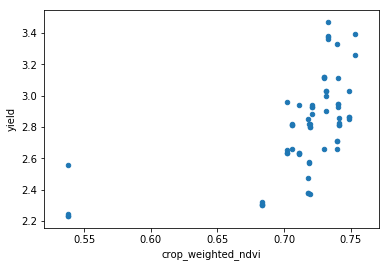

In [13]:
PREDICTION_DATE_MONTH = 2
PREDICTION_DATE_DAY = 25
tmp_df = country_ndvi_df.loc[(country_ndvi_df.metric_id == entities['metric_id']) & \
                             (country_ndvi_df.region_id == country_id) & \
                             (country_ndvi_df.end_date.map(lambda x: x.month) == PREDICTION_DATE_MONTH) &\
                             (country_ndvi_df.end_date.map(lambda x: x.day) == PREDICTION_DATE_DAY),:]
ym_df = pandas.DataFrame([{'year': end_date.year, 'yield': value}
                          for (end_date, value) in zip(yield_df.end_date, 
                                                   yield_df.value)])
cw_df = pandas.DataFrame([{'year': end_date.year, 'crop_weighted_ndvi': value}
                          for (end_date, value) in zip(tmp_df.end_date,
                                                       tmp_df.crop_weighted_value)])
ym_df = ym_df.merge(cw_df)
ym_df.plot.scatter(x='crop_weighted_ndvi', y = 'yield')
plt.show()

Indeed there seems to be a relationship between these two series, which means weighted NDVI on Feb 25 can be a reasonable predictor of final yield.

## Linear model
An obvious next step is to do a linear regression, where we model `y = a * x + b` where x is the crop weighted NDVI.

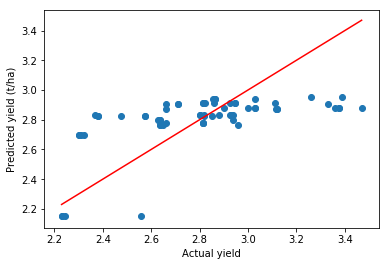

In [14]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
X = ym_df.loc[:,['crop_weighted_ndvi']]
lm.fit(X, ym_df['yield'])
lm_df =pandas.DataFrame([{'year': year, 'lm_yield': value}
                         for (year, value) in zip(ym_df.year, lm.predict(X))])
plt.scatter(ym_df['yield'], (lm_df['lm_yield']))
plt.xlabel("Actual yield")
plt.ylabel("Predicted yield (t/ha)")
plt.plot([min(ym_df['yield']), max(ym_df['yield'])], 
         [min(ym_df['yield']), max(ym_df['yield'])], color='red')
plt.show()

That is not a great fit, especially at higher yields, which is not surprising as we're using crop weights based on production rather than planted area.  Ideally to get the national yield, we would weight regional NDVI by  area.  Since production equals area multiplied by yield,  weighting by production instead of area will tend to over-wheight the high yield regions. Thus the model will be less accurate in years when the difference between regions is relatively large.

##  Quadratic+trend model
A polynomial of degree 2 should help us capture this second order effect, and provide a better fit. So we try to fit  `y = a * x^2 + b * x + c` where x is the  crop weighted NDVI. Further, as there appears to be a longer term trend of improvement in yields, we add the year as another dependent variable to capture the long term trend. So the model becomes `y = a * x^2 + b * x + c + d * t`, where t is time (year).

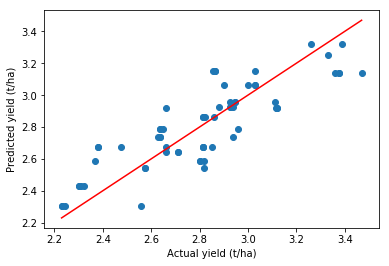

In [15]:
X2 = pandas.DataFrame(X.crop_weighted_ndvi.map(lambda x: x*x))
X2.rename(columns={'crop_weighted_ndvi': 'crop_weighted_ndvi2'}, inplace=True)
X2 = pandas.DataFrame([X2.crop_weighted_ndvi2, X.crop_weighted_ndvi, ym_df.year]).transpose()
qm = linear_model.LinearRegression()
qm.fit(X2, ym_df['yield'])
qm_df =pandas.DataFrame([{'year': year, 'qm_yield': value}
                         for (year, value) in zip(ym_df.year, qm.predict(X2))])
plt.scatter(ym_df['yield'], (qm_df['qm_yield']))
plt.plot([min(ym_df['yield']), max(ym_df['yield'])], 
         [min(ym_df['yield']), max(ym_df['yield'])], color='red')
plt.xlabel("Actual yield (t/ha)")
plt.ylabel("Predicted yield (t/ha)")
plt.show()

## Results
The second model seems to provide a better looking fit. Looking at the standard regression statistics to confirm that:

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
print('''Linear Model:
      Mean Squared Error: {}
      R2: {}'''.format(mean_squared_error(ym_df['yield'], lm.predict(X)),
                      r2_score(ym_df['yield'], lm.predict(X))))
print('''Quadtratic Model:
      Mean Squared Error: {}
      R2: {}'''.format(mean_squared_error(ym_df['yield'], qm.predict(X2)),
                          r2_score(ym_df['yield'], qm.predict(X2))))

Linear Model:
      Mean Squared Error: 0.0607627054352
      R2: 0.344356415216
Quadtratic Model:
      Mean Squared Error: 0.0261723611236
      R2: 0.717594196202


Indeed the quadratic+trend model
- has a root-mean-square error of about 0.026 t/ha i.e. less than 1% 
- explains about 72% of the variance in yields

To get more perspective, let's see how well the models' fit reality as a function of time. As we can see in the following figure, the quadratic model does indeed outperform the linear model, especially in the high yield years.

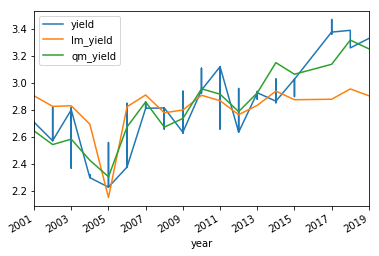

In [17]:
backtest_df = ym_df.merge(lm_df).merge(qm_df)
backtest_df.year = pandas.to_datetime(backtest_df.year, format='%Y')
fig, axes = plt.subplots(1, 1)
backtest_df.plot(x='year', y = ['yield', 'lm_yield', 'qm_yield'], ax=axes)
plt.show()

## Conclusion
A full blown model requires a lot more signals. For example, in a [Gro Yield Model](https://app.gro-intelligence.com/dictionary/sources/32) data series for soybeans in Brazil we would consider:

- [evapotranspiration](https://app.gro-intelligence.com/dictionary/items/4395) as an additional input
- district level historical yields from [CONAB](https://app.gro-intelligence.com/dictionary/sources/73) instead of only national level as above, and
- [pixel-level crop masks](https://github.com/gro-intelligence/api-client/wiki/Gro-crop-masks) to weight the NDVI, instead of the coarser province level production weights.

But this extremely simple crop model shows that a quick but reasonable fit (1% in-sample error-rate) can be achieved just using historical yields, production quantity, and NDVI.

##  Related links
- Gro web app [display](https://app.gro-intelligence.com/displays/25894) accompanying this example
- Soybean kit section of the [user manual](https://app.gro-intelligence.com/docs/user-manual#weather-data-soybean)
- Gro Yield Model [web page and papers](https://gro-intelligence.com/yield-model/)